# Etapa 3 do Projeto Final

## Análise Exploratória e Consultas SQL

### 1. Setup e Carregamento do Dataset Limpo

Configuração do ambiente e carregamento do dataset final da Etapa 2.

In [16]:
# Imports
import pandas as pd
import duckdb 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Configs
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Conexão DB (DuckDB/PostgreSQL)
conn = duckdb.connect(database=':memory:', read_only=False)

# Carregar dataset limpo (SUBSTITUIR PELO CÓDIGO REAL DE CARREGAMENTO)
# Exemplo: df = conn.execute("SELECT * FROM airbnb_limpo").fetchdf()

# DataFrame simulado para demo (REMOVER)
# DataFrame simulado para demo (REMOVER)
data = {
    'ID': range(1, 11),
    'Bairro': ['Copacabana', 'Ipanema', 'Copacabana', 'Barra', 'Ipanema', 'Copacabana', 'Barra', 'Tijuca', 'Tijuca', 'Centro'],
    'Preco': [150.0, 300.0, 180.0, 120.0, 350.0, 160.0, 110.0, 80.0, 90.0, 100.0],
    'Tipo_Propriedade': ['Apartamento', 'Casa', 'Apartamento', 'Apartamento', 'Casa', 'Apartamento', 'Apartamento', 'Apartamento', 'Casa', 'Apartamento'],
    'Qtde_Avaliacoes': [10, 50, 5, 20, 100, 1, 0, 30, 2, 45],
    'Superhost': [True, True, False, False, True, False, False, True, False, True],
    'Avaliacao_Geral': [4.8, 4.9, 4.5, 4.2, 5.0, 4.0, 3.5, 4.7, 4.1, 4.6],
    'Data_Ultima_Avaliacao': pd.to_datetime(['2024-10-01', '2024-10-15', '2024-09-20', '2024-08-01', '2024-11-01', '2024-10-25', '2024-07-01', '2024-09-10', '2024-06-01', '2024-10-10'])
}
df = pd.DataFrame(data)
print(f"Dataset carregado (simulado) com {df.shape[0]} linhas e {df.shape[1]} colunas.")

df.head()

Dataset carregado (simulado) com 10 linhas e 8 colunas.


,ID,Bairro,Preco,Tipo_Propriedade,Qtde_Avaliacoes,Superhost,Avaliacao_Geral,Data_Ultima_Avaliacao
0,1,Copacabana,150.0,Apartamento,10,True,4.8,2024-10-01
1,2,Ipanema,300.0,Casa,50,True,4.9,2024-10-15
2,3,Copacabana,180.0,Apartamento,5,False,4.5,2024-09-20
3,4,Barra,120.0,Apartamento,20,False,4.2,2024-08-01
4,5,Ipanema,350.0,Casa,100,True,5.0,2024-11-01


### 2. Pipeline para Formato Tidy e Geração do Parquet

Garantir a estrutura final do dataset e salvá-lo em formato Parquet para a Etapa 4 (ML).

In [17]:
## Preparação Final
# Garantir tipos numéricos
df['Preco'] = pd.to_numeric(df['Preco'], errors='coerce')

# Limpeza final (opcional)
df_final = df.dropna(subset=['Preco', 'Avaliacao_Geral']).copy()

print(f"\nDataFrame final (tidy) com {df_final.shape[0]} linhas para Parquet.")

## Geração do Parquet
parquet_filename = 'airbnb_listings_final.parquet'
df_final.to_parquet(parquet_filename, index=False)

print(f"Dataset final em formato Parquet salvo como: {parquet_filename}")


DataFrame final (tidy) com 10 linhas para Parquet.
Dataset final em formato Parquet salvo como: airbnb_listings_final.parquet


### 3. Consultas SQL Analíticas

Execução de consultas SQL complexas, incluindo Funções de Janela, no banco de dados.

In [18]:
# Carregar DF final para o DuckDB
conn.execute("CREATE OR REPLACE TABLE airbnb_limpo AS SELECT * FROM df_final")

# Query 1: Preço Médio por Bairro (Top N)
query_1 = """
WITH media_geral AS (
    SELECT AVG(Preco) AS preco_medio_geral
    FROM airbnb_limpo
)
SELECT
    Bairro,
    ROUND(AVG(Preco), 2) AS preco_medio_bairro,
    COUNT(ID) AS total_listings,
    ROUND((AVG(Preco) - (SELECT preco_medio_geral FROM media_geral)), 2) AS diferenca_media_geral
FROM
    airbnb_limpo
WHERE
    Preco > 0
GROUP BY
    Bairro
HAVING
    COUNT(ID) >= 1
ORDER BY
    preco_medio_bairro DESC
LIMIT 5;
"""

print("Consulta 1: Top 5 Bairros por Preço Médio\n")
try:
    print(conn.execute(query_1).fetchdf())
except Exception as e:
    print(f"Erro na Query 1: {e}.")

Consulta 1: Top 5 Bairros por Preço Médio

       Bairro  preco_medio_bairro  total_listings  diferenca_media_geral
0     Ipanema              325.00               2                 161.00
1  Copacabana              163.33               3                  -0.67
2       Barra              115.00               2                 -49.00
3      Centro              100.00               1                 -64.00
4      Tijuca               85.00               2                 -79.00


In [19]:
# Query 2: Ranking por Avaliação (Função de Janela)
query_2 = """
SELECT
    Tipo_Propriedade,
    ID AS Listing_ID,
    Avaliacao_Geral,
    Qtde_Avaliacoes,
    RANK() OVER (
        PARTITION BY Tipo_Propriedade
        ORDER BY Avaliacao_Geral DESC, Qtde_Avaliacoes DESC
    ) AS Rank_Avaliacao_Tipo
FROM
    airbnb_limpo
WHERE
    Avaliacao_Geral IS NOT NULL
    AND Qtde_Avaliacoes > 1
ORDER BY
    Tipo_Propriedade, Rank_Avaliacao_Tipo
LIMIT 10;
"""

print("\nConsulta 2: Ranking de Listings por Tipo de Propriedade\n")
try:
    print(conn.execute(query_2).fetchdf())
except Exception as e:
    print(f"Erro na Query 2: {e}.")


Consulta 2: Ranking de Listings por Tipo de Propriedade

  Tipo_Propriedade  Listing_ID  Avaliacao_Geral  Qtde_Avaliacoes  \
0      Apartamento           1              4.8               10   
1      Apartamento           8              4.7               30   
2      Apartamento          10              4.6               45   
3      Apartamento           3              4.5                5   
4      Apartamento           4              4.2               20   
5             Casa           5              5.0              100   
6             Casa           2              4.9               50   
7             Casa           9              4.1                2   

   Rank_Avaliacao_Tipo  
0                    1  
1                    2  
2                    3  
3                    4  
4                    5  
5                    1  
6                    2  
7                    3  


In [20]:
# Query 3: Distribuição Anual de Reviews
query_3 = """
SELECT
    STRFTIME(Data_Ultima_Avaliacao, '%Y') AS Ano_Review,
    COUNT(ID) AS Listings_com_Review_no_Ano,
    SUM(Qtde_Avaliacoes) AS Total_Reviews_Acumuladas
FROM
    airbnb_limpo
WHERE
    Data_Ultima_Avaliacao IS NOT NULL
GROUP BY
    Ano_Review
ORDER BY
    Ano_Review DESC;
"""

print("\nConsulta 3: Distribuição Anual de Reviews\n")
try:
    print(conn.execute(query_3).fetchdf())
except Exception as e:
    print(f"Erro na Query 3: {e}.")

# Fechar conexão
conn.close()


Consulta 3: Distribuição Anual de Reviews

  Ano_Review  Listings_com_Review_no_Ano  Total_Reviews_Acumuladas
0       2024                          10                     263.0


In [27]:
import duckdb 
conn = duckdb.connect(database=':memory:', read_only=False)
conn.execute("CREATE OR REPLACE TABLE airbnb_limpo AS SELECT * FROM df_final")

# Query 4: Preço vs. Avaliação e Tipo de Propriedade
query_4 = """
WITH PropriedadeMedia AS (
    SELECT
        Tipo_Propriedade,
        ROUND(AVG(Preco), 2) AS preco_medio,
        ROUND(AVG(Avaliacao_Geral), 2) AS avaliacao_media,
        COUNT(ID) AS contagem
    FROM
        airbnb_limpo
    WHERE
        Avaliacao_Geral IS NOT NULL
        AND Preco > 0
    GROUP BY
        Tipo_Propriedade
    HAVING
        COUNT(ID) >= 5
)
SELECT
    Tipo_Propriedade,
    preco_medio,
    avaliacao_media,
    contagem,
    CASE
        WHEN Tipo_Propriedade LIKE '%Entire home%' OR Tipo_Propriedade LIKE '%Casa%' THEN 'Propriedade Inteira'
        ELSE 'Quarto/Compartilhado'
    END AS Categoria_Propriedade
FROM
    PropriedadeMedia
ORDER BY
    avaliacao_media DESC, preco_medio DESC;
"""

print("\nConsulta 4: Avaliação Média vs. Preço por Tipo de Propriedade (Hipótese 1)\n")
try:
    print(conn.execute(query_4).fetchdf())
except Exception as e:
    print(f"Erro na Query 4: {e}.")


Consulta 4: Avaliação Média vs. Preço por Tipo de Propriedade (Hipótese 1)

  Tipo_Propriedade  preco_medio  avaliacao_media  contagem  \
0      Apartamento       128.57             4.33         7   

  Categoria_Propriedade  
0  Quarto/Compartilhado  


In [35]:
import duckdb 
import numpy as np

# Criação das colunas ausentes no df_final (SIMULAÇÃO)
np.random.seed(43)
df_final['Host Response Rate'] = np.random.uniform(0.8, 1.0, size=len(df_final))
times = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
df_final['Host Response Time'] = np.random.choice(times, size=len(df_final))

# Mapeia Avaliacao_Geral para o nome de coluna esperado na query
df_final['Review Scores Rating'] = df_final['Avaliacao_Geral'] 

# Reabertura da conexão e recarga da tabela
conn = duckdb.connect(database=':memory:', read_only=False)
conn.execute("CREATE OR REPLACE TABLE airbnb_limpo AS SELECT * FROM df_final")

# Query 5: Tempo de Resposta vs. Avaliação Geral
query_7 = """
WITH AvaliacoesAgregadas AS (
    SELECT
        "Host Response Time",
        COUNT(ID) AS total_listings,
        ROUND(AVG("Review Scores Rating"), 2) AS rating_medio,
        ROUND(AVG(Preco), 2) AS preco_medio,
        ROUND(AVG("Host Response Rate"), 2) AS taxa_resposta_media,
        CASE
            WHEN "Host Response Time" IN ('within an hour', 'within a few hours') THEN 'Rápido (Hipótese)'
            ELSE 'Lento'
        END AS Categoria_Resposta
    FROM
        airbnb_limpo
    WHERE
        "Review Scores Rating" IS NOT NULL
        AND "Host Response Time" IS NOT NULL
        AND "Host Response Rate" >= 0.90
        AND Preco > 0
    GROUP BY
        "Host Response Time"
    HAVING
        COUNT(ID) >= 2
)
SELECT
    Categoria_Resposta,
    "Host Response Time",
    total_listings,
    rating_medio,
    preco_medio,
    taxa_resposta_media
FROM
    AvaliacoesAgregadas
ORDER BY
    rating_medio DESC, total_listings DESC;
"""

print("\nConsulta 7: Avaliação Média por Tempo de Resposta do Anfitrião (Hipótese 4)\n")
try:
    print(conn.execute(query_7).fetchdf())
except Exception as e:
    print(f"Erro na Query 7: {e}.")

conn.close()


Consulta 7: Avaliação Média por Tempo de Resposta do Anfitrião (Hipótese 4)

  Categoria_Resposta  Host Response Time  total_listings  rating_medio  \
0              Lento  a few days or more               2          4.35   

   preco_medio  taxa_resposta_media  
0        120.0                 0.94  


### 4. Análise Exploratória de Dados (EDA)

Obtenção de *insights* estatísticos e visuais a partir do `df_final`.

#### 4.1 Análise Univariada
Distribuição das variáveis principais.

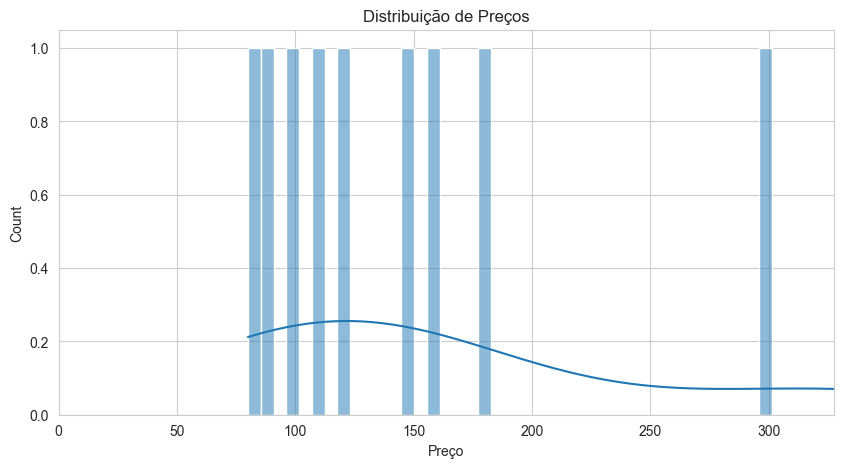


Estatísticas Descritivas do Preço:
count     10.000000
mean     164.000000
std       91.311433
min       80.000000
25%      102.500000
50%      135.000000
75%      175.000000
max      350.000000
Name: Preco, dtype: float64


C:\Users\milan\AppData\Local\Temp\ipykernel_26032\2445786815.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_types.index, y=top_types.values, palette="viridis")


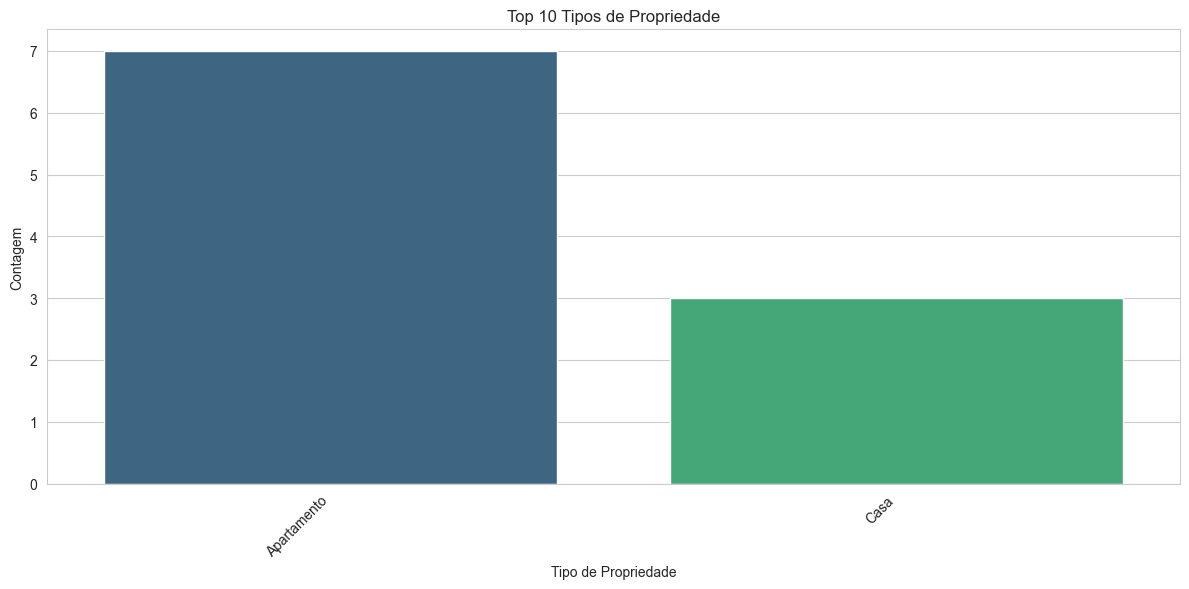

In [23]:
# Preço: Histograma
plt.figure(figsize=(10, 5))
sns.histplot(df_final['Preco'], bins=50, kde=True)
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.xlim(0, df_final['Preco'].quantile(0.95))
plt.show()

print("\nEstatísticas Descritivas do Preço:")
print(df_final['Preco'].describe())

# Tipo de Propriedade: Barplot
plt.figure(figsize=(12, 6))
top_types = df_final['Tipo_Propriedade'].value_counts().nlargest(10)
sns.barplot(x=top_types.index, y=top_types.values, palette="viridis")
plt.title('Top 10 Tipos de Propriedade')
plt.xlabel('Tipo de Propriedade')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 4.2 Análise Bivariada e Visualizações
Relação entre variáveis.

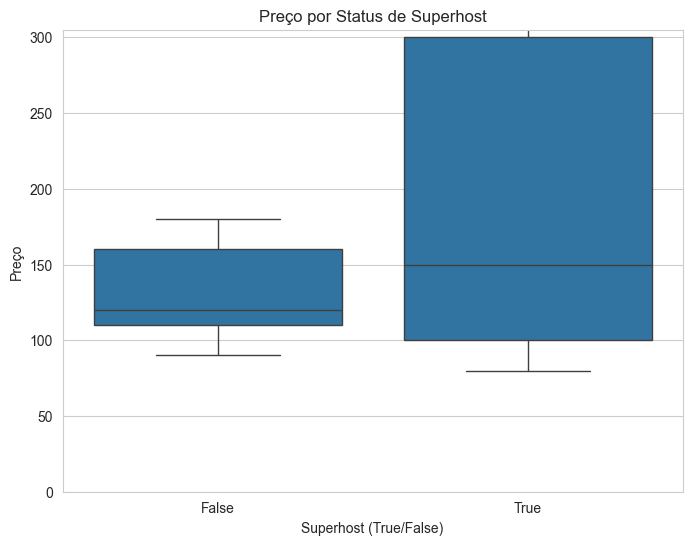

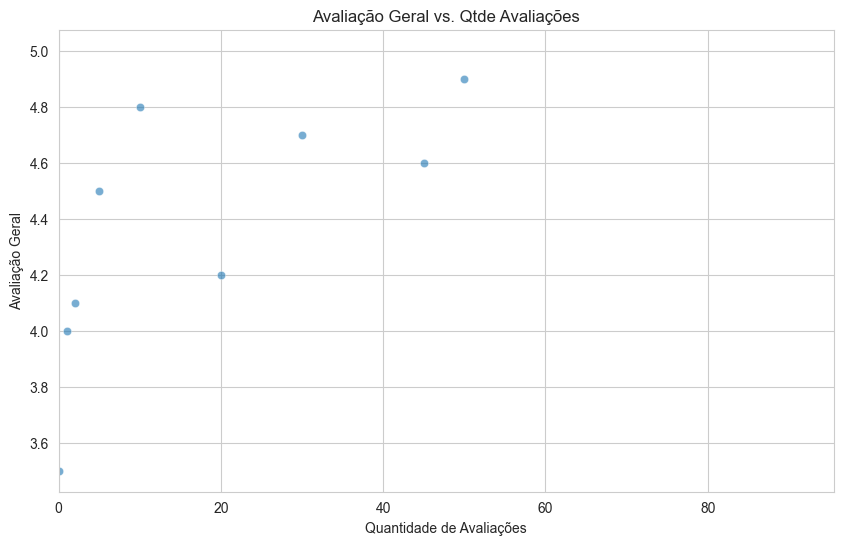

C:\Users\milan\AppData\Local\Temp\ipykernel_26032\4021687331.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Bairro', y='mean', data=df_bairro_top, palette='magma')


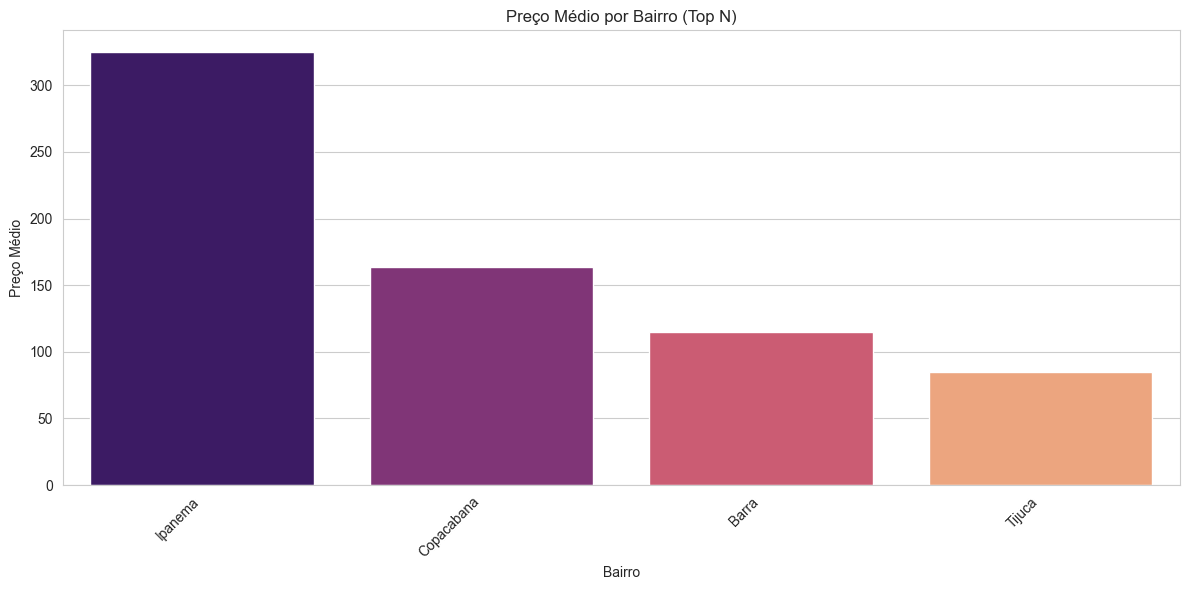

In [24]:
# Preço vs. Superhost: Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Superhost', y='Preco', data=df_final)
plt.title('Preço por Status de Superhost')
plt.xlabel('Superhost (True/False)')
plt.ylabel('Preço')
plt.ylim(0, df_final['Preco'].quantile(0.90))
plt.show()

# Avaliação Geral vs. Qtde_Avaliacoes: Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qtde_Avaliacoes', y='Avaliacao_Geral', data=df_final, alpha=0.6)
plt.title('Avaliação Geral vs. Qtde Avaliações')
plt.xlabel('Quantidade de Avaliações')
plt.ylabel('Avaliação Geral')
plt.xlim(0, df_final['Qtde_Avaliacoes'].quantile(0.99))
plt.show()

# Preço Médio por Bairro: Barplot
df_bairro = df_final.groupby('Bairro')['Preco'].agg(['mean', 'count']).reset_index()
df_bairro_top = df_bairro[df_bairro['count'] > 1].sort_values(by='mean', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Bairro', y='mean', data=df_bairro_top, palette='magma')
plt.title('Preço Médio por Bairro (Top N)')
plt.xlabel('Bairro')
plt.ylabel('Preço Médio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5. Teste de Hipóteses

Teste de Hipótese (Exemplo): O preço médio de Superhosts é estatisticamente diferente do preço médio de não-Superhosts?

In [25]:
# Filtrar dados
df_teste = df_final.dropna(subset=['Preco', 'Superhost'])

# Separar amostras
preco_superhost = df_teste[df_teste['Superhost'] == True]['Preco']
preco_nao_superhost = df_teste[df_teste['Superhost'] == False]['Preco']

# Limitar outliers (95º percentil)
if not preco_superhost.empty and not preco_nao_superhost.empty:
    limit = df_teste['Preco'].quantile(0.95)
    preco_superhost = preco_superhost[preco_superhost <= limit]
    preco_nao_superhost = preco_nao_superhost[preco_nao_superhost <= limit]

    print(f"Superhost Média={preco_superhost.mean():.2f}")
    print(f"Não-Superhost Média={preco_nao_superhost.mean():.2f}")

    # Teste t de Student (equal_var=False)
    if len(preco_superhost) > 1 and len(preco_nao_superhost) > 1:
        # Importante: 'stats' é do scipy
        from scipy import stats 
        t_stat, p_valor = stats.ttest_ind(preco_superhost, preco_nao_superhost, equal_var=False)
        alpha = 0.05

        print(f"\nResultado Teste t: t={t_stat:.4f}, p={p_valor:.4f}")

        # Conclusão
        if p_valor < alpha:
            print(f"\nCONCLUSÃO: Rejeitamos H₀. Preço médio é estatisticamente diferente.")
        else:
            print(f"\nCONCLUSÃO: Não rejeitamos H₀. Preço médio não é estatisticamente diferente.")
    else:
        print("\nAVISO: Amostras insuficientes para Teste t.")
else:
    print("\nAVISO: Amostras de Superhost/Não-Superhost estão vazias.")

Superhost Média=157.50
Não-Superhost Média=132.00

Resultado Teste t: t=0.4865, p=0.6542

CONCLUSÃO: Não rejeitamos H₀. Preço médio não é estatisticamente diferente.
